In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

FOLDERNAME = 'NLP_project/dataset'
assert FOLDERNAME is not None, "[!] Enter the foldername."

#Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd /content/drive/My\ Drive/$FOLDERNAME/

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1JLBuZnTQ8Cui6dbc8hlnFXrD_POoT_4F/NLP_project/dataset


In [ ]:
import torch

# Confirm that the GPU is detected

assert torch.cuda.is_available()

# Get the GPU device name.
device_name = torch.cuda.get_device_name()
n_gpu = torch.cuda.device_count()
print(f"Found device: {device_name}, n_gpu: {n_gpu}")
device = torch.device("cuda")

Found device: Tesla P100-PCIE-16GB, n_gpu: 1


In [ ]:
!pip install transformers -q
!pip install pandarallel -q
!pip install sentencepiece -q
!pip install neptune-client -q


     |████████████████████████████████| 3.4 MB 5.0 MB/s 
     |████████████████████████████████| 61 kB 462 kB/s 
     |████████████████████████████████| 895 kB 50.3 MB/s 
     |████████████████████████████████| 596 kB 48.3 MB/s 
     |████████████████████████████████| 3.3 MB 49.5 MB/s 
     |████████████████████████████████| 1.2 MB 5.1 MB/s 
     |████████████████████████████████| 287 kB 5.1 MB/s 
     |████████████████████████████████| 829 kB 58.8 MB/s 
     |████████████████████████████████| 53 kB 2.0 MB/s 
     |████████████████████████████████| 180 kB 51.5 MB/s 
     |████████████████████████████████| 131 kB 59.4 MB/s 
     |████████████████████████████████| 79 kB 7.9 MB/s 
     |████████████████████████████████| 8.4 MB 44.1 MB/s 
     |████████████████████████████████| 138 kB 60.8 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 127 kB 44.4 MB/s 
     |████████████████████████████████| 130 kB 59.3 MB/s 
     |███████████████████

In [ ]:
import numpy as np
import pandas as pd
import regex as re
import random
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,average_precision_score, precision_score,precision_recall_curve
from tqdm.notebook import tqdm
from tqdm import trange
import warnings
warnings.filterwarnings('ignore')
import pickle
import nltk
import math
import os
import json
import random
import re
import torch
import torch.nn as nn
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import AutoTokenizer, AutoModel



In [ ]:
reviews_df = pd.read_csv('/content/drive/MyDrive/NLP_project/dataset/yelp_hot_from_1M.csv')


In [ ]:
print(reviews_df.columns)

Index(['Unnamed: 0', 'date', 'useful', 'text', 'cool', 'funny', 'review_id',
       'user_id', 'stars', 'business_id'],
      dtype='object')


In [ ]:
print(reviews_df.shape)

(14473, 10)


In [ ]:
reviews_df = reviews_df[0:100]

In [ ]:
model_path = '/content/drive/MyDrive/NLP_project/trained_models/matching_model/arg_miningrobertalarge_SEED_4_dense_layer_epoc_3_lr_1e-05_b_s_16_accumulation_steps_2_input_type_kp_arg_topic_preee.pt'

In [ ]:
class NonPoolerTransformer(torch.nn.Module):

    def __init__(self):
        super(NonPoolerTransformer, self).__init__()
        
        #Instantiating Pre trained model object 
        self.model_layer = AutoModel.from_pretrained(model_path)

        #Layers
        # the first dense layer will have 768 if base model is used and 
        # 1024 if large model is used

        self.dense_layer_1 = nn.Linear(1024, 256)
        self.dropout = nn.Dropout(0.4)
        self.dense_layer_2 = nn.Linear(256, 128)
        self.dropout_2 = nn.Dropout(0.2)
        self.cls_layer = nn.Linear(128, 1, bias = True)
        self.sigmoid = nn.Sigmoid()

    def forward(self,input_ids, attention_masks):

        hidden_state = self.model_layer(input_ids=input_ids, attention_mask=attention_masks)[0]
        pooled_output = hidden_state[:, 0]

        x = self.dense_layer_1(pooled_output)
        x = self.dropout(x)
        x_1 = self.dense_layer_2(x)
        x_2 = self.dropout_2(x_1)

        logits = self.cls_layer(x_2)
        output = self.sigmoid(logits)

        return output

In [ ]:
model = torch.load(model_path)
tokenizer = AutoTokenizer.from_pretrained('roberta-large')


Downloading:   0%|          | 0.00/482 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [ ]:
#make reviews and key_points dataset
key_point_df =df = pd.read_csv('/content/drive/MyDrive/NLP_project/dataset/NLP keypoints - Hotels.csv')
positive_kp_df = key_point_df['Positive']
# print(positive_kp_df.head())
negative_kp_df = key_point_df['Negative']
# print(negative_kp_df.head())

reviews_text_df = reviews_df['text']

reviews_list = reviews_text_df.values.tolist()
kp_list = positive_kp_df.values.tolist()
kp_list.extend(negative_kp_df.values.tolist())

print(reviews_list)
print(kp_list)

['b"I\'ve stayed at many Marriott and Renaissance Marriott\'s and this was a huge disappointment! The front desk and atrium is nice..there is a starbucks on site which is nice.\\n\\nThe rooms are run down and old.  There is a flat screen but that is to be expected of a Renaissance.\\n\\nWe got this hotel via Priceline at a rate of $75/night...good deal for the price but this is not a true Renaissance."', 'b"Am I crazy for giving anything MBTA-related four stars? Maybe.\\n\\nRating the red line against other public transit services I\'ve used in the US and abroad, no, it can\'t hold a candle to anything in Japan or some of the better Metro lines in Paris. But those lines are well-funded. That\'s simply not the case anywhere in the US.\\n\\nSimply because the T shuts down at night, it\'s cleaner than anything in NYC. Sure, it\'s not as fast, but Boston\'s not nearly as big as NYC, so it\'s fast enough.  Compared to any other public transit in the US, the red line is awesome. \\n\\nLook, 

In [ ]:
print(key_point_df.shape)

(30, 2)


In [ ]:
final_list = []

for review in reviews_list:
  for kp in kp_list:
    final_list.append([review,kp])

dataset = pd.DataFrame(final_list,columns = ['review','key_point'])

In [ ]:
print(dataset.head())

                                              review                          key_point
0  b"I've stayed at many Marriott and Renaissance...    Very comfortable and safe place
1  b"I've stayed at many Marriott and Renaissance...  All new appliances and very clean
2  b"I've stayed at many Marriott and Renaissance...              The location is great
3  b"I've stayed at many Marriott and Renaissance...               The service was good
4  b"I've stayed at many Marriott and Renaissance...      The hotel staff was wonderful


In [ ]:
from torch.utils.data import (DataLoader, RandomSampler, WeightedRandomSampler, SequentialSampler, TensorDataset)



In [ ]:
def matching_score(dataframe):
  all_attention_masks=[]
  all_input_ids=[]
  match_scores = []

  #print(dataframe.shape[0])
  for i in range(dataframe.shape[0]):
    encoded_input = tokenizer(dataframe.iloc[i]['all_text'], padding='max_length')
    #print(encoded_input['attention_mask'])
    # print(len(encoded_input['attention_mask']))
    all_attention_masks.append(encoded_input['attention_mask'][0:512])
    all_input_ids.append(encoded_input['input_ids'][0:512])

  all_attention_masks = torch.tensor(all_attention_masks).squeeze()
  all_input_ids = torch.tensor(all_input_ids).squeeze()


  dataset = TensorDataset(all_input_ids, all_attention_masks)


  test_dataloader = DataLoader(dataset, batch_size=1)
      
  with torch.no_grad():
      acc_epoch = []

      epoch_iterator = tqdm(test_dataloader, desc="Iteration")
      for step, batch in enumerate(epoch_iterator):
          model.eval()
              

          b_input_ids, b_input_mask = batch[0].to(device), batch[1].to(device)
          ypred = model(b_input_ids, b_input_mask)
          # print(ypred)
          match_scores.append(ypred[0][0].item())
  return match_scores


In [ ]:
sentence_df = pd.DataFrame([], columns =['Review', 'Sentence', 'Key_point'])

In [ ]:
sentence_df.shape

(0, 3)

In [ ]:
for index, row in dataset.iterrows():
  if row.review!= None:
    splitted = row.review.split('.')
    for sentence in splitted:
      print(sentence)
      new_row = [row.review, sentence, row.key_point]
      sentence_df.loc[len(sentence_df.index)] = new_row
  else:
      continue

In [ ]:
sentence_df.head()

,Review,Sentence,Key_point
0,"b""I've stayed at many Marriott and Renaissance...","b""I've stayed at many Marriott and Renaissance...",Very comfortable and safe place
1,"b""I've stayed at many Marriott and Renaissance...",,Very comfortable and safe place
2,"b""I've stayed at many Marriott and Renaissance...",there is a starbucks on site which is nice,Very comfortable and safe place
3,"b""I've stayed at many Marriott and Renaissance...",\n\nThe rooms are run down and old,Very comfortable and safe place
4,"b""I've stayed at many Marriott and Renaissance...",There is a flat screen but that is to be exp...,Very comfortable and safe place


In [ ]:
sentence_df['all_text'] = sentence_df['Sentence']+sentence_df['Key_point']

In [ ]:
sentence_df.head()

,Review,Sentence,Key_point,all_text
0,"b""I've stayed at many Marriott and Renaissance...","b""I've stayed at many Marriott and Renaissance...",Very comfortable and safe place,"b""I've stayed at many Marriott and Renaissance..."
1,"b""I've stayed at many Marriott and Renaissance...",,Very comfortable and safe place,Very comfortable and safe place
2,"b""I've stayed at many Marriott and Renaissance...",there is a starbucks on site which is nice,Very comfortable and safe place,there is a starbucks on site which is niceVery...
3,"b""I've stayed at many Marriott and Renaissance...",\n\nThe rooms are run down and old,Very comfortable and safe place,\n\nThe rooms are run down and oldVery comfort...
4,"b""I've stayed at many Marriott and Renaissance...",There is a flat screen but that is to be exp...,Very comfortable and safe place,There is a flat screen but that is to be exp...


In [ ]:
sentence_df.to_csv('sentence_splitted_review_kp_hotel.csv')

In [ ]:
print(sentence_df.shape)

(24000, 4)


In [ ]:
sentence_df['score'] = matching_score(sentence_df) 

Iteration:   0%|          | 0/24000 [00:00<?, ?it/s]

In [ ]:
sentence_df.to_csv('sentence_df_scores_hotel.csv')

In [ ]:
sentence_df.head()

,Review,Sentence,Key_point,all_text,score
0,"b""I've stayed at many Marriott and Renaissance...","b""I've stayed at many Marriott and Renaissance...",Very comfortable and safe place,"b""I've stayed at many Marriott and Renaissance...",0.005572
1,"b""I've stayed at many Marriott and Renaissance...",,Very comfortable and safe place,Very comfortable and safe place,0.006735
2,"b""I've stayed at many Marriott and Renaissance...",there is a starbucks on site which is nice,Very comfortable and safe place,there is a starbucks on site which is niceVery...,0.003849
3,"b""I've stayed at many Marriott and Renaissance...",\n\nThe rooms are run down and old,Very comfortable and safe place,\n\nThe rooms are run down and oldVery comfort...,0.012478
4,"b""I've stayed at many Marriott and Renaissance...",There is a flat screen but that is to be exp...,Very comfortable and safe place,There is a flat screen but that is to be exp...,0.003281


In [ ]:
new_df = pd.DataFrame([], columns =['Review', 'Key_point', 'Score'])

i=0
while i<sentence_df.shape[0]:
    rowSeries = sentence_df.iloc[i]
    if rowSeries['Review']!= None:
      len_splitted = len(rowSeries['Review'].split('.'))
      max_index = sentence_df['score'][i:i+len_splitted].idxmax()
      line = sentence_df.iloc[max_index]
      new_row = [line.Review, line.Key_point, line.score]
      new_df.loc[len(new_df.index)] = new_row
      i = i+len_splitted
    else:
       i = i+1

In [ ]:
print(new_df.shape)

(3000, 3)


In [ ]:
new_df.head()

,Review,Key_point,Score
0,"b""I've stayed at many Marriott and Renaissance...",Very comfortable and safe place,0.012478
1,"b""I've stayed at many Marriott and Renaissance...",All new appliances and very clean,0.022723
2,"b""I've stayed at many Marriott and Renaissance...",The location is great,0.007457
3,"b""I've stayed at many Marriott and Renaissance...",The service was good,0.006423
4,"b""I've stayed at many Marriott and Renaissance...",The hotel staff was wonderful,0.006218


In [ ]:
matched_df = pd.DataFrame([], columns =['Review', 'Key_point', 'Score'])

In [ ]:
pos_matched_df = pd.DataFrame([], columns =['Review', 'Key_point', 'Score'])
neg_matched_df = pd.DataFrame([], columns =['Review', 'Key_point', 'Score'])
no_matched_df = pd.DataFrame([], columns =['Review', 'Key_point', 'Score'])

i=0
while i<new_df.shape[0]:
  flag = False
  for j in range(30):
    rowSeries = new_df.iloc[i+j]
    if rowSeries['Score']>0.95:
      flag = True
      new_row = [rowSeries.Review, rowSeries.Key_point, rowSeries.Score]
      pos_matched_df.loc[len(pos_matched_df.index)] = new_row
  for j in range(30,60):
    rowSeries = new_df.iloc[i+j]
    if rowSeries['Score']>0.95:
      flag = True
      new_row = [rowSeries.Review, rowSeries.Key_point, rowSeries.Score]
      neg_matched_df.loc[len(neg_matched_df.index)] = new_row
  if flag == False:
    row = new_df.iloc[i]
    new_row = [row.Review, row.Key_point, 0]
    no_matched_df.loc[len(no_matched_df.index)] = new_row
  i = i+60

In [ ]:
pos_matched_df.head()

,Review,Key_point,Score
0,"b""Am I crazy for giving anything MBTA-related ...",All new appliances and very clean,0.975637
1,"b""Am I crazy for giving anything MBTA-related ...",The location is great,0.966825
2,"b""Am I crazy for giving anything MBTA-related ...",The service was good,0.970725
3,"b""Am I crazy for giving anything MBTA-related ...",We would definitely stay there again,0.983939
4,"b""Am I crazy for giving anything MBTA-related ...",I love this place,0.977652


In [ ]:
neg_matched_df.head()

,Review,Key_point,Score
0,"b""I've stayed at many Marriott and Renaissance...",It was dirty and very worn,0.992424
1,"b""Am I crazy for giving anything MBTA-related ...",Nothing special and definitely not great,0.956063
2,"b""Am I crazy for giving anything MBTA-related ...",It was completely gross,0.953732
3,"b""Am I crazy for giving anything MBTA-related ...",The pictures were deceiving,0.959195
4,"b""Am I crazy for giving anything MBTA-related ...",Would never recommend this place,0.984208


In [ ]:
no_matched_df.head()
no_matched_df['Review'][0]

"b'Not enough service-13 minutes sometimes for another train to come\\nThree words: Braintree/Ashmont split=Delays\\nVery, very rude staff\\n\\nI.e.:\\nWATCH THE DOORS!  THE DOORS WILL BE CLOSING!  WATCH THE DOORS! screeched at obnoxious volume, whereas service delays are made at a level no one can hear\\n\\nHave been called names by bus drivers in the good old days for being slow with putting in money and/or scanning my pass (and I always have them out ahead of time)\\n\\nWould gladly pay more if they addressed their problems, but it all goes to debt reduction\\n\\n\\nBut I do get reliably each day where I want to go and can read books while doing so'"

In [ ]:
review_coverage = 1 - (no_matched_df.shape[0]/new_df.shape[0])
print(review_coverage)

0.992


In [ ]:
pos_kp_coverage = ((pos_matched_df.groupby('Key_point').size()/reviews_df.shape[0])*100)
pos_kp_coverage_top10 = pos_kp_coverage.nlargest(10)
print(pos_kp_coverage_top10)

Key_point
Excellent food and great service        22.678182
Excellent and fast service              18.616290
They're clean and updated               18.237867
The staff is hospitable and friendly    18.140517
We would definitely stay there again    16.696805
I definitely recommend this hotel!      14.799473
The service was good                    14.698198
All new appliances and very clean       12.960921
Very comfortable and safe place         12.719105
The beds are so comfortable             12.648855
dtype: float64


In [ ]:
neg_kp_coverage = ((neg_matched_df.groupby('Key_point').size()/reviews_df.shape[0])*100)
neg_kp_coverage_top10 = neg_kp_coverage.nlargest(10)
print(neg_kp_coverage_top10)

Key_point
It was dirty and very worn                  18.260849
Nothing special and definitely not great    16.569239
Not worth the money                         14.923184
Food is not great but good                  14.426294
Would never recommend this place            12.394544
The elevator was broken                     10.974322
There was no microwave or fridge            10.734669
No hot water in my room                     10.724828
Parking garage is terrible                  10.687834
Shitty furniture and shitty tv              10.435424
dtype: float64


In [ ]:
arr = pos_kp_coverage_top10.to_numpy()
print(arr)

x =list(range(len(arr)))
print(pos_kp_coverage_top10.index)
y= ['kp'+str(xi+1) for xi in x]

[22.67818152 18.61629024 18.23786689 18.14051692 16.69680475 14.79947254
 14.69819767 12.96092148 12.71910535 12.64885469]
Index(['Excellent food and great service', 'Excellent and fast service',
       'They're clean and updated', 'The staff is hospitable and friendly',
       'We would definitely stay there again',
       'I definitely recommend this hotel!', 'The service was good',
       'All new appliances and very clean', 'Very comfortable and safe place',
       'The beds are so comfortable'],
      dtype='object', name='Key_point')


Text(0.5, 1.0, 'Positive Key point Coverage for Hotels')

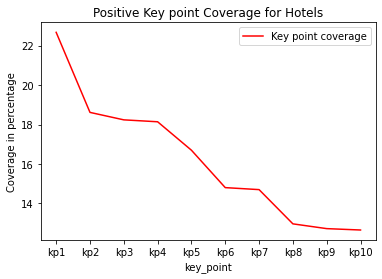

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
plt.plot(y,arr,'r',label='Key point coverage')
plt.xlabel("key_point")

ax.set_xticks(y)
plt.ylabel("Coverage in percentage")
plt.legend()
plt.title("Positive Key point Coverage for Hotels")

In [ ]:
arr = neg_kp_coverage_top10.to_numpy()
print(arr)

x =list(range(len(arr)))
print(neg_kp_coverage_top10.index)
y= ['kp'+str(xi+1) for xi in x]

[18.26084949 16.56923937 14.92318433 14.42629439 12.39454413 10.97432241
 10.73466862 10.7248283  10.68783376 10.43542414]
Index(['It was dirty and very worn',
       'Nothing special and definitely not great', 'Not worth the money',
       'Food is not great but good', 'Would never recommend this place',
       'The elevator was broken', 'There was no microwave or fridge',
       'No hot water in my room', 'Parking garage is terrible',
       'Shitty furniture and shitty tv'],
      dtype='object', name='Key_point')


Text(0.5, 1.0, 'Negative Key point Coverage for Hotels')

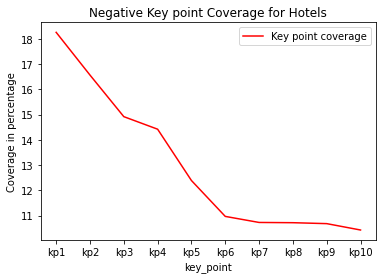

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
plt.plot(y,arr,'r',label='Key point coverage')
plt.xlabel("key_point")

ax.set_xticks(y)
plt.ylabel("Coverage in percentage")
plt.legend()
plt.title("Negative Key point Coverage for Hotels")

In [ ]:
pos_kp_coverage.to_csv('pos_kp_coverage_hotels.csv')

In [ ]:
neg_kp_coverage.to_csv('neg_kp_coverage_hotels.csv')

In [ ]:
pos_kp_coverage

In [ ]:
matched_df = pd.DataFrame([], columns =['Review', 'Key_point', 'Score'])

i=0
while i<new_df.shape[0]:
  flag = False
  for j in range(30):
    rowSeries = new_df.iloc[i+j]
    if rowSeries['Score']>0.95:
      flag = True
      new_row = [rowSeries.Review, rowSeries.Key_point, rowSeries.Score]
      matched_df.loc[len(matched_df.index)] = new_row
  for j in range(30,60):
    rowSeries = new_df.iloc[i+j]
    if rowSeries['Score']>0.95:
      flag = True
      new_row = [rowSeries.Review, rowSeries.Key_point, rowSeries.Score]
      matched_df.loc[len(matched_df.index)] = new_row
  if flag == False:
    row = new_df.iloc[i]
    new_row = [row.Review, row.Key_point, 0]
    matched_df.loc[len(matched_df.index)] = new_row
  i = i+60

In [ ]:
matched_df.head()

,Review,Key_point,Score
0,"b""I've stayed at many Marriott and Renaissance...",It was dirty and very worn,0.992424
1,"b""Am I crazy for giving anything MBTA-related ...",All new appliances and very clean,0.975637
2,"b""Am I crazy for giving anything MBTA-related ...",The location is great,0.966825
3,"b""Am I crazy for giving anything MBTA-related ...",The service was good,0.970725
4,"b""Am I crazy for giving anything MBTA-related ...",We would definitely stay there again,0.983939


In [ ]:
matched_df.groupby('Review').size().to_numpy().mean

array([37,  1,  8,  8,  2,  3,  1,  2,  1,  1,  2,  1,  1,  1,  1,  3,  1,
       60,  1,  1, 46,  1,  1,  1,  5,  1, 52, 31,  3,  2,  2,  1,  2,  1,
        1,  1,  1,  1,  1,  1,  1,  6,  9,  1,  1,  1,  6,  1,  1,  1])

In [ ]:
np.mean(matched_df.groupby('Review').size().to_numpy())

6.38

In [ ]:
arr = np.array([18.6,16.3,14.5,13.7,12.85,10.76,10.43,10.12,9.4,8.4])
arr1 = np.array([14.62,14.38,12.98,11.54,11.46,11.17,10.75,9.54,8.92,8.83])

Text(0.5, 1.0, 'Positive Key point Coverage for Restaurants')

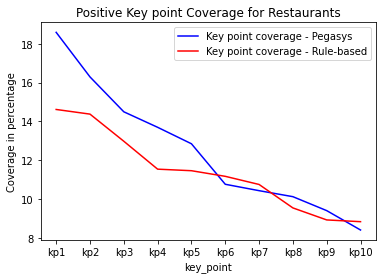

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
plt.plot(y,arr,'b',label='Key point coverage - Pegasys')
plt.plot(y,arr1,'r',label='Key point coverage - Rule-based')
plt.xlabel("key_point")

ax.set_xticks(y)
plt.ylabel("Coverage in percentage")
plt.legend()
plt.title("Positive Key point Coverage for Restaurants")

In [ ]:
arr = np.array([16.5,16.35,14.74,12.7,11.67,10.5,9.73,8.5,7.5,6.9])
arr1 = np.array([18.4,15.5,15.13,14.89,14.53,13.31,12.5,9.3,9,6])

Text(0.5, 1.0, 'Negative Key point Coverage for Restaurants')

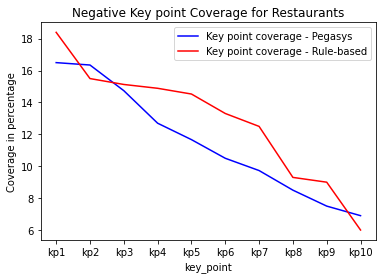

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
plt.plot(y,arr,'b',label='Key point coverage - Pegasys')
plt.plot(y,arr1,'r',label='Key point coverage - Rule-based')
plt.xlabel("key_point")

ax.set_xticks(y)
plt.ylabel("Coverage in percentage")
plt.legend()
plt.title("Negative Key point Coverage for Restaurants")